### This notebook is the tutorial that comparison of solving TSP using MIP by PuLP and Deep Reinforcement Learning by PyTorch.

In [1]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Traveling Salesman Problem; TSP

In [2]:
# Define TSP

n_customer = 14
n_point = n_customer + 1

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0

df

,x,y
0,0,0
1,13,95
2,78,9
3,75,14
4,37,3
5,1,19
6,10,89
7,67,40
8,32,74
9,59,99


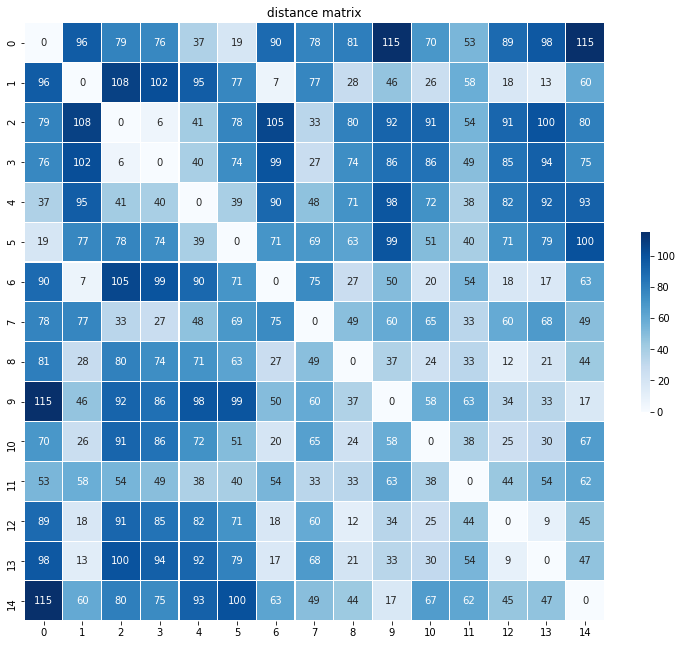

In [3]:
# Get the distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

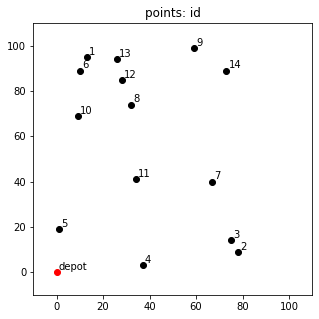

In [4]:
# Check TSP state

plt.figure(figsize=(5, 5))

# Draw the problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

### 1. Solving using Mixed Integer Problem; MIP by PuLP

In [5]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 4.4 MB/s 


In [6]:
import pulp

In [7]:
%%time

# Set the problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# Set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
# We need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')

# Set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))

# Set constrains
for i in range(n_point):
    problem += x[i, i] == 0

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1

# Eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
            
# Solve the problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: user 24.4 ms, sys: 4.96 ms, total: 29.3 ms
Wall time: 2.24 s


(1, 'Optimal', 371.8792316020913)

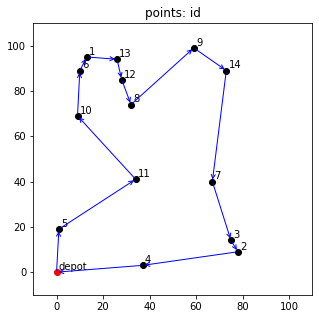

In [8]:
# Check TSP state and optimized route

plt.figure(figsize=(5, 5))

# Draw the problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
        
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

# Draw the optimal route
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()

### 2. Solving using Deep Reinforcement Learning by PyTorch

### Use the following deep learning model and deep reinforcement learning architecture

* <i>Pointer Networks</i>: https://arxiv.org/abs/1506.03134
* <i>Neural Combinatorial Optimization with Reinforcement Learning</i>: https://arxiv.org/abs/1611.09940

In [9]:
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

use_cuda = torch.cuda.is_available()

torch.__version__, use_cuda

('1.4.0', True)

In [10]:
def reward(sample_solution, use_cuda=use_cuda):
    batch_size = sample_solution[0].size(0)
    n = len(sample_solution) # sample_solution is seq_len of [batch_size]
    tour_len = Variable(torch.zeros([batch_size])).cuda() if use_cuda else Variable(torch.zeros([batch_size]))
    for i in range(n - 1):
        tour_len += torch.norm(sample_solution[i] - sample_solution[i + 1], dim=1)
    tour_len += torch.norm(sample_solution[n - 1] - sample_solution[0], dim=1)

    return tour_len

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=use_cuda):
        super(Attention, self).__init__()
        self.use_tanh = use_tanh
        self.C = C

        # Bahdanau algo
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)

        V = torch.cuda.FloatTensor(hidden_size) if use_cuda else torch.FloatTensor(hidden_size)
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        # query = [batch_size, hidden_size]
        # ref   = [batch_size, seq_len, hidden_size]
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        
        # Bahdanau algo
        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)                           # [batch_size x hidden_size x           1]
        ref   = self.W_ref(ref)                                            # [batch_size x hidden_size x     seq_len] 
        expanded_query = query.repeat(1, 1, seq_len)                       # [batch_size x hidden_size x     seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)      # [batch_size x           1 x hidden_size]
        logits = torch.bmm(V, torch.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * torch.tanh(logits)
            
        return ref, logits

In [12]:
class GraphEmbedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda=use_cuda):
        super(GraphEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.use_cuda = use_cuda
        
        self.embedding = nn.Parameter(torch.FloatTensor(input_size, embedding_size)) 
        self.embedding.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def forward(self, inputs):
        # inputs = [batch_size, input_size, seq_len]
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        embedding = self.embedding.repeat(batch_size, 1, 1)  
        embedded = []
        inputs = inputs.unsqueeze(1)
        for i in range(seq_len):
            embedded.append(torch.bmm(inputs[:, :, :, i].float(), embedding))
        embedded = torch.cat(embedded, 1)
        return embedded

In [13]:
class PointerNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, seq_len, n_glimpses, tanh_exploration, use_tanh, use_cuda=use_cuda):
        super(PointerNet, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        self.embedding = GraphEmbedding(2, embedding_size, use_cuda=use_cuda)
        self.encoder   = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder   = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer   = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse   = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def apply_mask_to_logits(self, logits, mask, idxs):
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs):
        # inputs = [batch_size, 1, seq_len]
        batch_size = inputs.size(0)
        seq_len    = inputs.size(2)
        
        embedded = self.embedding(inputs)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        prev_probs    = []
        prev_idxs     = []
        mask          = torch.zeros(batch_size, seq_len).byte().cuda() if self.use_cuda else torch.zeros(batch_size, seq_len).byte()        
        idxs          = None
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        for i in range(seq_len):
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            probs = F.softmax(logits)
            
            idxs = probs.multinomial(num_samples=1).squeeze(1)
            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).data.any():
                    idxs = probs.multinomial(num_samples=1).squeeze(1)
                    break
            decoder_input = embedded[[i for i in range(batch_size)], idxs.data, :] 
            
            prev_probs.append(probs)
            prev_idxs.append(idxs)
            
        return prev_probs, prev_idxs

In [14]:
class NeuralCombinatorialOptimization(nn.Module):
    def __init__(self, embedding_size, hidden_size, seq_len, n_glimpses, tanh_exploration, use_tanh, reward, use_cuda=use_cuda):
        super(NeuralCombinatorialOptimization, self).__init__()
        self.reward   = reward
        self.use_cuda = use_cuda
        
        self.actor = PointerNet(embedding_size, hidden_size, seq_len, n_glimpses, tanh_exploration, use_tanh, use_cuda)

    def forward(self, inputs):
        # inputs = [batch_size, input_size, seq_len]
        batch_size = inputs.size(0)
        input_size = inputs.size(1)
        seq_len    = inputs.size(2)
        
        probs, action_idxs = self.actor(inputs)
       
        actions = []
        inputs = inputs.transpose(1, 2)
        for action_id in action_idxs:
            actions.append(inputs[[x for x in range(batch_size)], action_id.data, :])
            
        action_probs = []    
        for prob, action_id in zip(probs, action_idxs):
            action_probs.append(prob[[x for x in range(batch_size)], action_id.data])

        R = self.reward(actions, self.use_cuda)
        
        return R, action_probs, actions, action_idxs

In [15]:
class Trainer:
    def __init__(self, model, train_data, max_grad_norm=2., use_cuda=use_cuda):
        self.model         = model
        self.use_cuda      = use_cuda
        
        self.train_data    = train_data.unsqueeze(0)
        self.train_data    = Variable(self.train_data).cuda() if use_cuda else Variable(self.train_data)

        self.actor_optim   = optim.Adam(model.actor.parameters(), lr=1e-4)
        self.max_grad_norm = max_grad_norm
        
        self.train_loss = []
        self.train_tour = []
        self.epochs     = 0
        
    def train(self, n_epochs):
        critic_exp_mvg_avg = torch.zeros(1).cuda() if self.use_cuda else torch.zeros(1)
        
        self.model.train() # Set train mode
        iterator = tqdm(range(n_epochs))
        
        for epoch in iterator:
            iterator.set_description(f'epoch {epoch + 1}/{n_epochs}')
            
            R, probs, actions, actions_idxs = self.model(self.train_data)

            critic_exp_mvg_avg = (critic_exp_mvg_avg * beta) + ((1. - beta) * R.mean())
            advantage = R - critic_exp_mvg_avg

            logprobs = 0
            for prob in probs: 
                logprob = torch.log(prob)
                logprobs += logprob
            logprobs[logprobs < -1000] = 0.  

            reinforce = advantage * logprobs
            actor_loss = reinforce.mean()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.actor.parameters(), float(self.max_grad_norm), norm_type=2)

            self.actor_optim.step()
            critic_exp_mvg_avg = critic_exp_mvg_avg.detach()

            l = float(actor_loss.data)
            r = float(R.mean().data)
            self.train_loss.append(l)
            self.train_tour.append(r)
            self.epochs += 1
            
            iterator.set_postfix(loss='{}'.format(l), reward='{}'.format(r))
                    
        self.model.eval() # Set not train mode
            
    def predict(self):
        R, probs, actions, actions_idxs = self.model(self.train_data)
        return R, probs, actions, actions_idxs

In [16]:
# Set hyper parameters

embedding_size   = 128
hidden_size      = 128
n_glimpses       = 1
tanh_exploration = 10
use_tanh         = True

beta             = 0.99
max_grad_norm    = 2.

In [17]:
# Define the model

model = NeuralCombinatorialOptimization(embedding_size, hidden_size, n_point, n_glimpses, tanh_exploration, use_tanh, reward, use_cuda=use_cuda)

if use_cuda:
    model = model.cuda()

In [18]:
train_data = torch.tensor(df.values.transpose(), dtype=torch.float32)
trainer = Trainer(model, train_data)

In [19]:
%%time

trainer.train(n_epochs=1000)


CPU times: user 1min 25s, sys: 2.21 s, total: 1min 27s
Wall time: 1min 32s


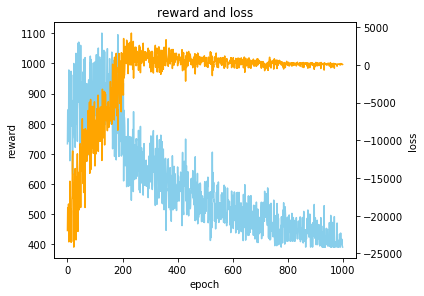

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(trainer.train_tour, color='skyblue')
ax1.set_ylabel('reward')

ax2.plot(trainer.train_loss, color='orange')
ax2.set_ylabel('loss')

ax1.set_xlabel('epoch')

fig.tight_layout()
plt.title('reward and loss')
plt.show()

In [21]:
# Predict using trained model
R, probs, actions, actions_idxs = trainer.predict()

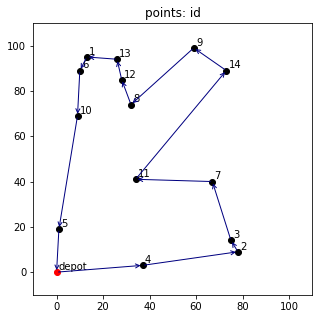

In [22]:
plt.figure(figsize=(5, 5))

# Draw the problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
        
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

# Draw the optimal route
routes = [int(tensor) for tensor in actions_idxs]
routes = [(routes[i-1], routes[i]) for i in range(len(routes))]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='navy')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()

### Thanks.